In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd

# About
This notebook is the first step in playing with the activity dataset. The data is spread across a few datasets, and in this notebook I filter out uneeded data and merge the datasets into a single dataset.

# Dataset

Source: [Heterogeneity Activity Recognition Data Set](https://archive.ics.uci.edu/ml/datasets/Heterogeneity+Activity+Recognition)

The dataset and accompanying research can befound at UCIs dataset repository. The dataset is provided as a single archive. For my convenience I separated the included datasets into their own archives.

In [2]:
data_directory = os.environ["DATASET"] + "/heterogeneity_activity_recognition"
phone_accelerometer_path = f"{data_directory}/phones_accelerometer.zip"
phone_gyroscope_path = f"{data_directory}/phones_gyroscope.zip"
output_path = f"{data_directory}/processed/phones.zip"

In [3]:
pd.read_csv(phone_accelerometer_path).head(1)

Index   Arrival_Time        Creation_Time         x         y         z  \
0      0  1424696633908  1424696631913248572 -5.958191  0.688065  8.135345   

  User   Model    Device     gt  
0    a  nexus4  nexus4_1  stand

In [4]:
pd.read_csv(phone_gyroscope_path).head(1)

Index   Arrival_Time        Creation_Time         x         y         z  \
0      0  1424696633909  1424696631914042029  0.013748 -0.000626 -0.023376   

  User   Model    Device     gt  
0    a  nexus4  nexus4_1  stand

# Preprocessing

**`read`** opens a device dataset, and performs some basic processing. Columns are pruned and column names are normalized, categorial data is converted to categorical respresentations, and the dataset is indexed on time. The arrival time is used for the time index to provide a standard across all devices.

In [5]:
def read(path):
    return (
        pd.read_csv(path)
        .rename(columns=str.lower)
        .rename(columns={"gt": "target"})
        .set_index("arrival_time")
        .drop(columns=["creation_time", "device", "index", "model"])
        .assign(
            target=lambda df: pd.Categorical(df["target"]),
            user=lambda df: pd.Categorical(df["user"])
        )
    )

# Merge

**`df`** is the accelerometer and gyroscope datasets merged on their time axis. This produces rows with incomplete data where one dataset had a timestamp that the other did not. In those cases the data is dropped.

In [6]:
%time df = (read(phone_accelerometer_path).join(read(phone_gyroscope_path), lsuffix="_accel", rsuffix="_gyro").dropna()); df.head(1)

CPU times: user 56.1 s, sys: 5.87 s, total: 1min 1s
Wall time: 1min 2s


x_accel   y_accel   z_accel user_accel target_accel    x_gyro  \
arrival_time                                                                    
1424686733391 -2.779668  1.908179  8.927979          g        stand  0.015577   

                 y_gyro    z_gyro user_gyro target_gyro  
arrival_time                                             
1424686733391 -0.043371 -0.014661         g       stand

## Merge Conflicts

Each dataset has a target and a user column that gets a unique suffix for each dataset. To make things easier to work with one of those columns is dropped, and the column names are returned to `target` and `user`.

In [7]:
def normalize_target(df):
    return (
        df.rename(columns={"target_accel": "target"})
        .drop(columns=["target_gyro"])
    )

In [8]:
def normalize_user(df):
    return (
        df.rename(columns={"user_accel": "user"})
        .drop(columns=["user_gyro"])
    )

# Apply Processing

In [9]:
%%time 
df = (
    df.pipe(normalize_target)
    .pipe(normalize_user)
    .sort_index(axis="columns")
)

CPU times: user 377 ms, sys: 172 ms, total: 550 ms
Wall time: 551 ms


# Visualize

In [10]:
f"total number of rows in the dataset {len(df)}"

'total number of rows in the dataset 11056161'

---
Random slice of the dataset

In [11]:
df.sample(n=10)

target user    x_accel    x_gyro   y_accel    y_gyro  \
arrival_time                                                              
1424782683861    stairsup    d  -2.836334  1.047287  0.767807 -0.104126   
1424696870404       stand    a  -6.146240  0.043066  0.317917 -0.019853   
1424779969856        walk    f  -2.039860  0.014420 -0.919373  0.041702   
1424787631963         sit    e   3.811569 -0.003738  0.134075  0.026596   
1424779510746         sit    f   7.817184 -0.006058 -0.658783  0.010437   
1424786004422  stairsdown    b  -3.369369 -0.021439 -0.101776 -1.067093   
1424700083281        walk    h  -6.988724 -0.321077  1.879883  0.007807   
1424698108828  stairsdown    a -11.368607 -0.347900  4.935089 -0.198883   
1424697535194        walk    a   3.661932  0.512405 -1.019930 -0.087967   
1424778253473        bike    i  -1.817199  0.271835 -0.185551  0.091904   

                 z_accel    z_gyro  
arrival_time                        
1424782683861   6.329834 -0.560272  
1424696870404   8.022278 -0.024740  
1424779969856  11.080365 -0.155975  
1424787631963   8.992621 -0.008057  
1424779510746   6.079697 -0.000305  
1424786004422   8.467209  0.579422  
1424700083281  13.371963  0.384755  
1424698108828  15.077499 -0.846252  
1424697535194   5.868188 -0.706604  
1424778253473   9.063251  0.038422

---
Number of occurrences by activity categry

In [12]:
df.target.value_counts()

walk          2266727
sit           2062641
stand         1809463
stairsup      1762269
bike          1675293
stairsdown    1479768
Name: target, dtype: int64

---
Sensor readings per user

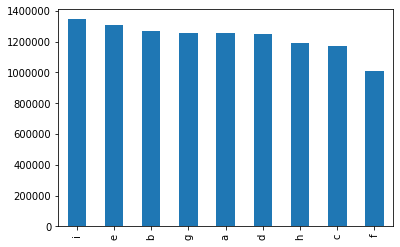

In [13]:
df.user.value_counts().plot(kind="bar");

---
Breakdown of the actions taken

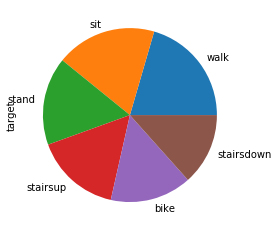

In [14]:
df.target.value_counts().plot(kind="pie");

# Export Dataset

In [15]:
%time df.to_csv(output_path)

CPU times: user 2min 16s, sys: 1.65 s, total: 2min 17s
Wall time: 2min 18s
